We are interested in comparing simulations to real data according to summary statistics. One simulated dataset with the same number of cells and genes will be compared to each real dataset, using parameters learned from the dataset. The following characteristics will be compared:

- distribution of gene mean expression
- distribution of gene variance
- gene mean-variance relationship
- distribution of zeros per gene
- gene mean-zeros relationship
- distribution of cell library sizes
- distribution of zeros per cell

Cells from hematopoietic progenitors to differentiated blood cells

**Human haematopoietic stem cell lineage commitment is a continuous process**  
Lars Velten _et al._  
Nature Cell Biology, 2018

In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [2]:
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from prosstt import count_model as cmod
from prosstt import tree_utils as tu

In [3]:
from comparison_functions import *

set random seed for reproducibility

In [4]:
rseed = 42
np.random.seed(rseed)

In [5]:
real_name = "velten"
real_cells = pd.read_csv("/home/soedinglaptop/Documents/data/steinmetz/all_cells.txt",
                         sep=" ", header=0, index_col=0)
real_genes = pd.read_csv("/home/soedinglaptop/Documents/data/steinmetz/all_genes.txt",
                         sep=" ", header=0, index_col=0)

real_stats = [real_cells, real_genes]

The authors find a star topology with the different hematopoietic lineages radiating from a progenitor population, so we mimic that:

In [6]:
top = [[0,1], [0,2], [0,3], [0,4], [0,5]]

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
G = np.sum((real_genes.loc['means'] > 0) & (real_genes.loc['var'] > 0))
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=30)

uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)

/home/soedinglaptop/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/soedinglaptop/miniconda3/envs/py37/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


learn summary statistics and set simulation parameters accordingly

In [7]:
scale_params, alpha_mean, beta_mean, proposed_means = sut.learn_data_summary(real_cells, real_genes, uMs)
t.add_genes(uMs, proposed_means)
scale_mean, scale_var = scale_params

In [8]:
# use default variance for hyperparameter sampling
alpha_var = np.log(1.5)
beta_var = np.log(1.5)

alpha = np.exp(random.normal(loc=alpha_mean, scale=alpha_var, size=t.G))
beta = np.exp(random.normal(loc=beta_mean, scale=beta_var, size=t.G)) + 1
X, labs, brns, scalings = sim.sample_density(t, 1035, alpha=alpha, beta=beta,
                                             scale=True, scale_mean=scale_mean, scale_v=scale_var)

sim_means = np.mean(X, axis=0)
sim_vars = np.var(X, axis=0)
sim_zeros_gene = np.sum(X==0, axis=0)
sim_zeros_cell = np.sum(X==0, axis=1)
sim_totals = np.sum(X, axis=1)

sim_means[sim_means<=0] = 1e-6
sim_vars[sim_vars<=0] = 1e-6

simulated = [sim_means, sim_vars, sim_zeros_gene, sim_zeros_cell, sim_totals]

Plot the summary statistics from both the real and simulated data.

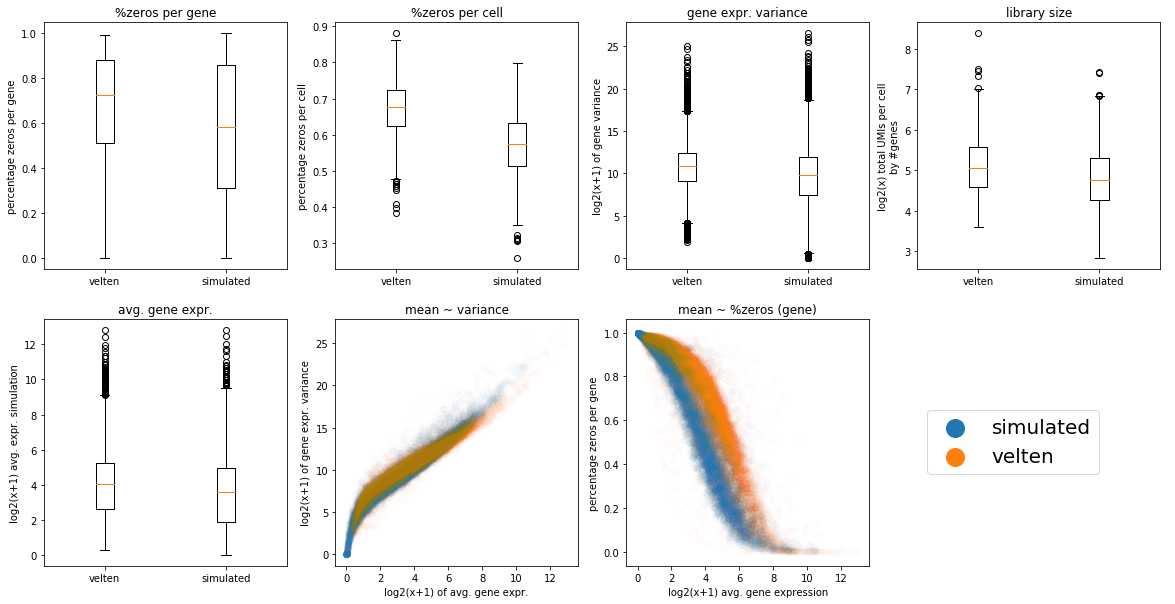

In [9]:
plot(real_name, real_stats, simulated, alpha=0.01)